In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from transit_periodogram.transit_periodogram import transit_periodogram

<Container object of 3 artists>

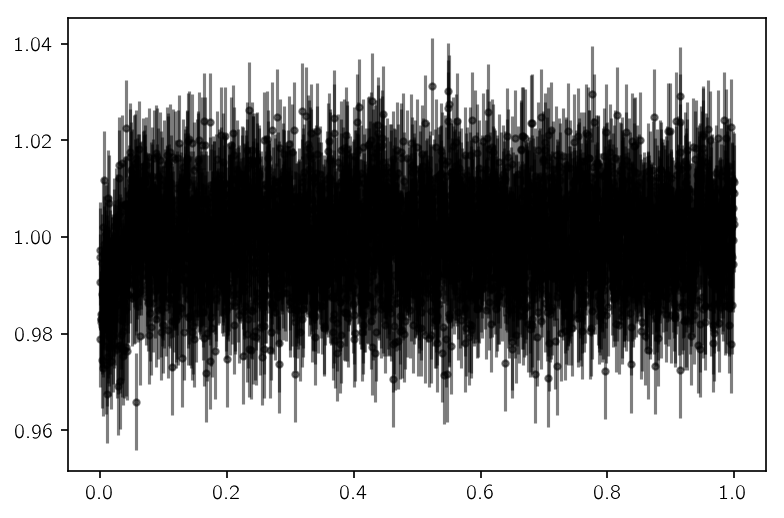

In [62]:
np.random.seed(41)

time = np.linspace(0, 60, 3000)

flux_err = 0.01+ np.zeros_like(time)
period = 5

transit_depth = 0.01
transit_duration = 0.2
transit_time = 0.5*transit_duration

flux = np.ones_like(time)
flux[np.abs((time - transit_time + 0.5*period) % period - 0.5*period) < 0.5*transit_duration] = 1.0 - transit_depth

flux += flux_err * np.random.randn(len(flux))

plt.errorbar((time%period)/period, flux, yerr=flux_err, fmt=".k", alpha=0.5)
# plt.xlim(0, );

In [63]:
df = 0.5 / (time.max() - time.min())
fmax = 0.1 / np.median(np.diff(time))
freq = np.arange(10*df, fmax, 0.02*df)
periods = 1.0 / freq
len(freq)

29491

In [64]:
oversample=10
periods, periodogram, log_likelihood, depth_snr, depth, depth_ivar, phase, best_durations = \
    transit_periodogram(time, flux-np.median(flux), periods, [0.1*transit_duration, transit_duration, 0.5*transit_duration],
                        flux_err=flux_err, oversample=oversample)
ind = np.argmax(periodogram)
periods[ind], phase[ind], (transit_time - 0.5*transit_duration)%period

(5.000000000000079, 0.0, 0.0)

(1, 2)

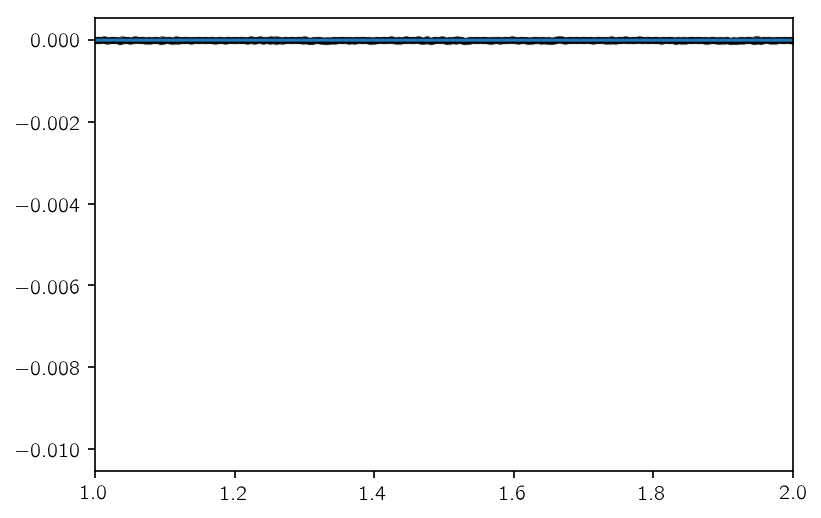

In [55]:
d_bin = transit_duration / oversample
bins = np.arange(0, period+d_bin, d_bin)
a, _ = np.histogram(time%period, bins, weights=(flux-np.median(flux))/flux_err**2)
b, _ = np.histogram(time%period, bins, weights=1/flux_err**2)
a = np.concatenate(([0], a, a[:oversample]))
b = np.concatenate(([0], b, b[:oversample]))
a = np.cumsum(a)
b = np.cumsum(b)

fi = (a[oversample:] - a[:-oversample])
ii = (b[oversample:] - b[:-oversample])
fo = np.sum((flux-np.median(flux))/flux_err**2) - fi
io = np.sum(1/flux_err**2) - ii

plt.errorbar((time%period), flux-np.median(flux), yerr=flux_err, fmt=".k", alpha=0.5, zorder=-100, ms=5)
plt.plot(bins, (a[oversample:] - a[:-oversample]) / (b[oversample:] - b[:-oversample]))
plt.axvline(transit_time - 0.5*transit_duration)
plt.xlim(1, 2)

In [15]:
bins[np.argmin((a[oversample:] - a[:-oversample]) / (b[oversample:] - b[:-oversample]))] + 0.5*transit_duration

4.2990000000000004

95


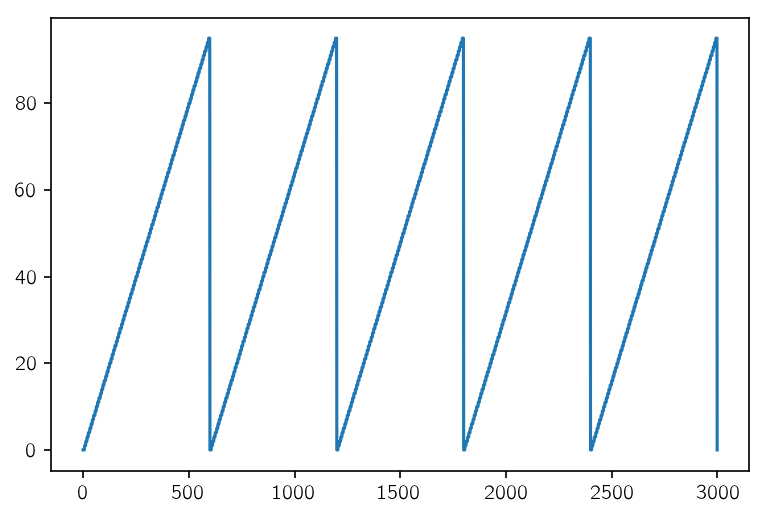

In [11]:
ind = np.asarray((time % periods[0]) / d_bin, dtype=int)
print(max(ind))
plt.plot(ind)

In [12]:
len(bins)

96

In [32]:
periodogram

NameError: name 'periodogram' is not defined

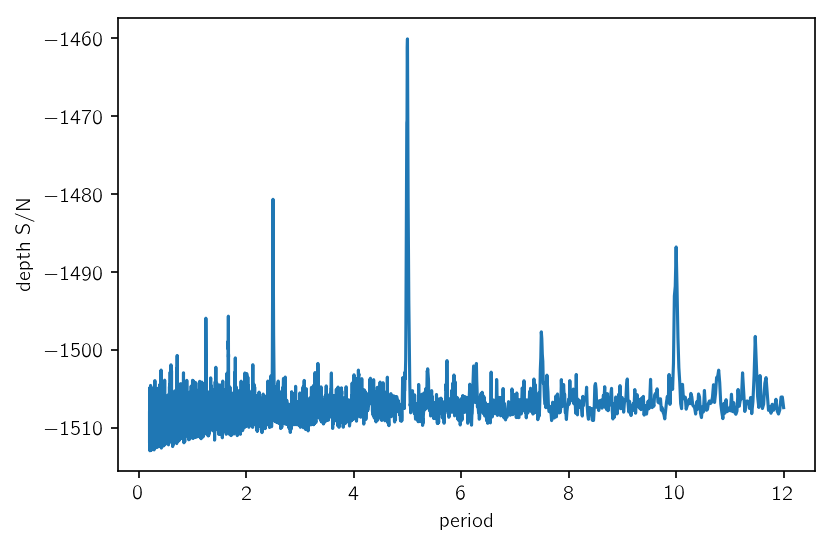

In [28]:
plt.plot(periods, periodogram)
plt.xlabel("period")
plt.ylabel("depth S/N");

In [25]:
periods, periodogram, log_likelihood, depth_snr, depth, depth_ivar, phase, best_durations = \
    transit_periodogram(time, flux, periods, [transit_duration, 0.5*transit_duration,
                                              10 * transit_duration],
                        flux_err=flux_err, method="likelihood")

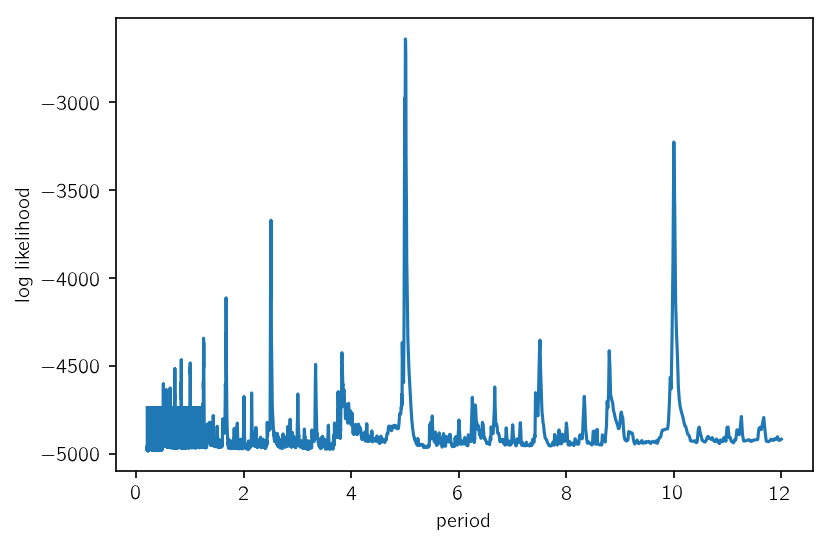

In [11]:
plt.plot(periods, periodogram)
plt.xlabel("period")
plt.ylabel("log likelihood");

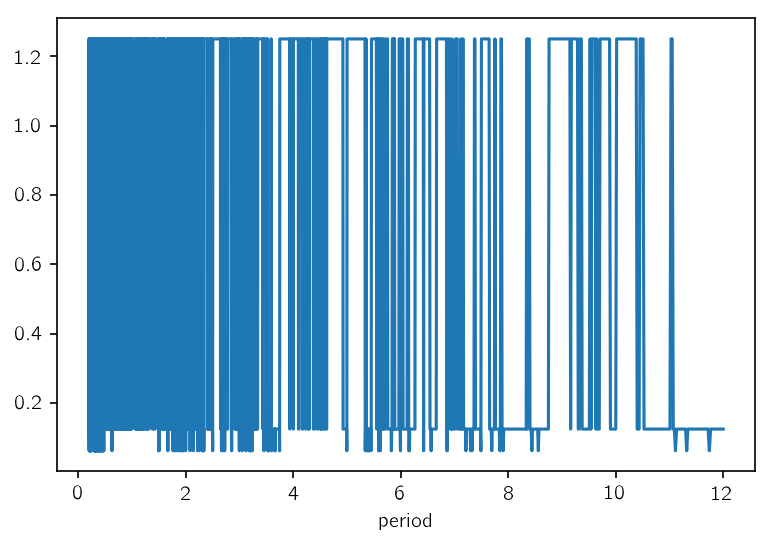

In [12]:
plt.plot(periods, best_durations)
plt.xlabel("period")
# plt.ylabel("log likelihood");

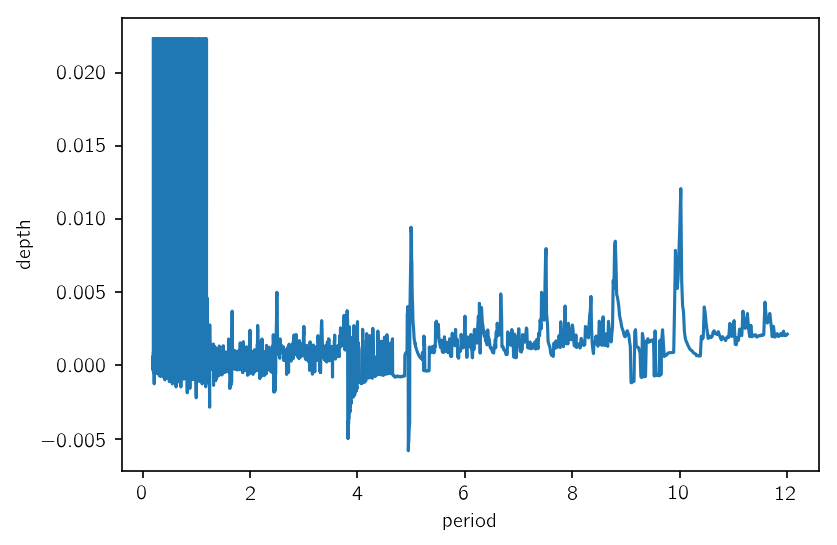

In [13]:
plt.plot(periods, depth)
plt.xlabel("period")
plt.ylabel("depth");

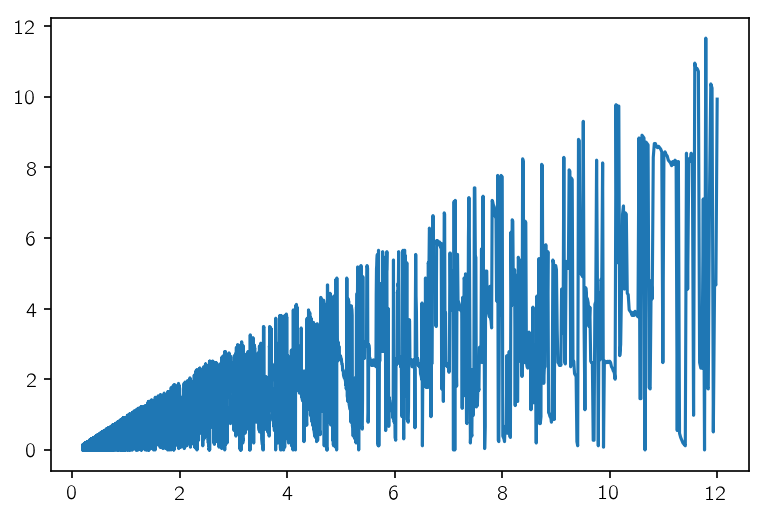

In [13]:
plt.plot(periods, phase)

In [14]:
ind = np.argmax(periodogram)
periods[ind], phase[ind], depth[ind]

(5.000000000000079, 2.5918139392115793, 0.010251703728149542)

In [15]:
period, transit_time

(5, 2.5)

In [16]:
len(freq), len(periods)

(29491, 29491)

In [17]:
import bls

In [18]:
%%timeit
u = np.empty_like(time)
v = np.empty_like(time)
nf = len(freq)
fmin = np.min(freq)
df = freq[1] - freq[0]
nb = 400
qmi = transit_duration/period
qma = transit_duration/period
results = bls.eebls(time, flux, u, v, nf, fmin, df, nb, qmi, qma)

1 loop, best of 3: 318 ms per loop


In [19]:
%%timeit
transit_periodogram(time, flux, periods, transit_duration, flux_err=flux_err)

1 loop, best of 3: 725 ms per loop
